<a href="https://colab.research.google.com/github/CourageousGoofy/Market_Timing/blob/master/SMA_Cross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## XIU ETF 20d-50d SMA Cross

import pandas as pd
import numpy as np
from pandas_datareader import data
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# useful reference
# https://pandas.pydata.org/pandas-docs/stable/reference/window.html


Download Security Data

In [0]:
tickers = ['XIU.TO', 'IWM', 'QQQ']
start= '2009-12-31'
end = '2019-3-31'
# Data sources can be yahoo, morning star, etc. 
price = data.DataReader(tickers,'yahoo',start,end)['Adj Close']
price = price.fillna(method='ffill')

# price_LQD = dat[('Adj Close','LQD')]
# XCS.to_csv("XCS.csv") #XCS = pd.read_csv("test_data.csv")


Daily Return/Risk/Skew Profile

Symbols          IWM       QQQ    XIU.TO
Date                                    
2009-12-31       NaN       NaN       NaN
2010-01-04       NaN       NaN       NaN
2010-01-05       NaN       NaN       NaN
2010-01-06       NaN       NaN       NaN
2010-01-07       NaN       NaN       NaN
2010-01-08       NaN       NaN       NaN
2010-01-11       NaN       NaN       NaN
2010-01-12       NaN       NaN       NaN
2010-01-13       NaN       NaN       NaN
2010-01-14       NaN       NaN       NaN
2010-01-15       NaN       NaN       NaN
2010-01-18       NaN       NaN       NaN
2010-01-19       NaN       NaN       NaN
2010-01-20       NaN       NaN       NaN
2010-01-21       NaN       NaN       NaN
2010-01-22       NaN       NaN       NaN
2010-01-25       NaN       NaN       NaN
2010-01-26       NaN       NaN       NaN
2010-01-27       NaN       NaN       NaN
2010-01-28       NaN       NaN       NaN
2010-01-29       NaN       NaN       NaN
2010-02-01       NaN       NaN       NaN
2010-02-02      

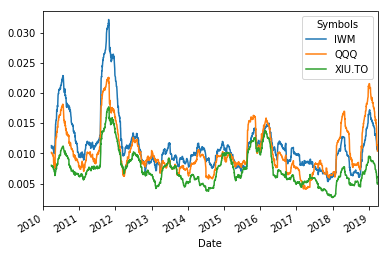

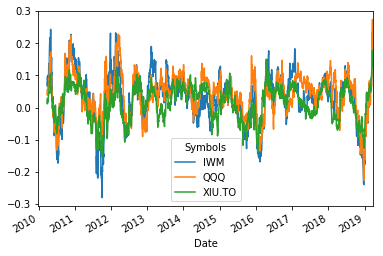

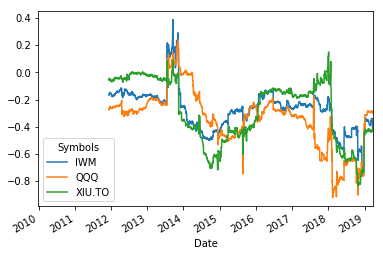

In [0]:
ret_daily = price.pct_change(periods = 1) 
rolling_period = 60
std_roll = ret_daily.rolling(rolling_period).std()
ret_roll = price.pct_change(periods = rolling_period)
skew_roll = ret_daily.rolling(500).skew()
print(skew_roll)
std_roll.plot()
ret_roll.plot()
skew_roll.plot()

Periodic Skew Profile

In [0]:

n = 10 # set return periods
ret = price.pct_change(periods = n)
skew_roll = ret.rolling(500).skew()
skew_roll.plot()
print(skew_roll)


SMA Backtest

In [0]:
short_period = 21
long_period = 50

price_xiu = price['XIU.TO']
smas = price_xiu.rolling(short_period).mean()
smal = price_xiu.rolling(long_period).mean()
signal = (((smas - smal)>0)*1-0.5)*2

print(signal)
print(signal.isna().sum())

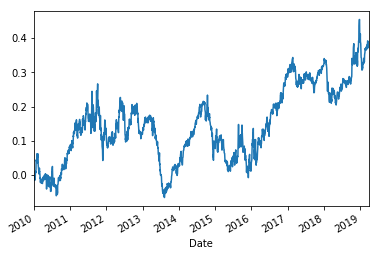

In [0]:
sim_ret = signal*ret_daily['XIU.TO']
gross_sim_ret = sim_return + 1 
cum_sim_ret = gross_sim_ret.cumprod()-1
#print(sim_return)
#print(cum_sim_ret)
cum_sim_ret.plot()

In [0]:
#var = ret.var(axis=0)
#print(var)
#std = ret.std(axis=0)
#print(std)


Risk Budgeting Framework

In [0]:
def calculate_portfolio_var(w,V):
    # function that calculates portfolio variance
    # V is covariance matrix (n x n)
    # w is asset weight (1 x n)
    w = np.matrix(w)
    return w.dot(V).dot(w.T)
  
  
def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V.dot(w.T)
    # Risk Contribution
    RC = MRC*w.T/float(sigma)
    return RC
  
def risk_objective_function(w0, V, TRC):
    # calculate sum of squares of excess/shortfall risk contribution 
    # w0 represents current asset weight. type = list. i.e. [0.3, 0.7]
    # V is covariance matrix (n x n). type = DataFrame 
    # TRC, target_risk_contribution_pct, is target % of current portoflio volatility. type = lsit. i.e. [0.2,0.2,0.2]

    initial_portoflio_vol =  np.sqrt(calculate_portfolio_var(w0,V))[0,0] # initial/current portfolio risk 
    target_contributional_vol = pd.DataFrame(TRC)*initial_portoflio_vol # portfolio risk target
    target_contributional_vol = np.matrix(target_contributional_vol) # convert to matrix
    
    initial_contributional_vol = calculate_risk_contribution(x,V)
    initial_contributional_vol = np.matrix(initial_contributional_vol) 
    J = sum(np.square(initial_contributional_vol-target_contributional_vol))[0,0] # sum of squared error
    return J 
  
def total_weight_constraint(w):
  # define equality constract f(x) = b
  # w, asset weight. type = list. i.e. [0.3, 0.7]
  # exposure, gross exposure. type = float. i.e. 1.5
    return np.sum(w)-1

def long_only_constraint(w):
  # define inequality constract f(x) = b
    return w

In [0]:
from scipy.optimize import minimize

w0 = [0.2, 0.6, 0.2] # initial weight
V = cov # covariance matrix
TRC = [0.25, 0.5, 0.25] # target risk contr. as % of inital portfolio vol 

cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint}) # 'ineq'constraint by default means non-negative
res= minimize(risk_objective_function, w0, args=[cov, TRC], method='SLSQP',constraints=cons, options={'disp': True})
w_rb = np.asmatrix(res.x)

TypeError: ignored

In [0]:
#verify the above functiosn work

w0 = [0.2, 0.6, 0.2]
V = cov
TRC =pd.DataFrame([0.33, 0.33, 0.33])

initial_portoflio_vol =  np.sqrt(calculate_portfolio_var(w0,V))[0,0] # initial/current portfolio risk 
print( initial_portoflio_vol)
#print(type(initial_portoflio_vol))
target_contributional_vol = pd.DataFrame(TRC)*initial_portoflio_vol # portfolio risk target
m1 = np.matrix(target_contributional_vol)
print(TRC)
print(target_contributional_vol)
print(target_contributional_vol.shape)
#print(pd.DataFrame(TRC))
initial_contributional_vol = calculate_risk_contribution(x,V)
m2 = np.matrix(initial_contributional_vol)
print(initial_contributional_vol)
print(initial_contributional_vol.shape)
J = sum(np.square(m1-m2)) # sum of squared error
J0 = np.square(m1-m2)
print(J)
print(J0)

res = risk_objective_function(w0, V, TRC)
print(res)

0.07506509630548344
      0
0  0.33
1  0.33
2  0.33
          0
0  0.024771
1  0.024771
2  0.024771
(3, 1)
                0
Symbols          
LQD      0.003928
SPY      0.067413
TLT      0.003725
(3, 1)
[[0.00269575]]
[[0.00043447]
 [0.0018183 ]
 [0.00044297]]
0.002695746424810596


In [0]:
m1 - m2

matrix([[ 0.02084394],
        [-0.04264155],
        [ 0.02104696]])

In [0]:
print(TRC*2)
print(type(TRC))


      0
0  0.66
1  0.66
2  0.66
<class 'pandas.core.frame.DataFrame'>


In [0]:
risk_objective_function (x, pars)

Exception: ignored

In [0]:
# verify the functions are correct
w = [0.2, 0.6, 0.2] # initialize weights
v = cov
var = calculate_portfolio_var(w,v)
std = np.sqrt(var)
rc = calculate_risk_contribution(w,cov)
print('Portfolio volatility is \n', float(std))
print('Pct % risk contribution is ', rc/float(std))


Portfolio volatility is 
 0.07506509630548344
Pct % risk contribution is                  0
Symbols          
LQD      0.052322
SPY      0.898061
TLT      0.049617


In [0]:
sigma = float(sigma)
type(sigma)

float

In [0]:
v

Symbols,LQD,SPY,TLT
Symbols,,,
LQD,0.001942,0.000564,0.003738
SPY,0.000564,0.014799,-0.002790
TLT,0.003738,-0.002790,0.011622


In [0]:
print(np.matrix(w).T)
print(np.matrix(w).T.shape)

[[0.]
 [0.]
 [1.]]
(3, 1)


In [0]:
w.dot(vv).dot(w.T)

matrix([[1.]])

In [0]:
type(v)

pandas.core.frame.DataFrame

In [0]:
# Searching for optimal return period
# range length - m
m = 50 
acf_values = list(np.zeros(m))
for x in list(range(m)):
    n = x+1
    rt0 = dat.pct_change(periods=n) # calulate n-period return
    rt = rt0[n:] # remove NAs from the series
    acf_values[x] = rt.autocorr(lag=n)
acf_values



# check autocorrelation
n = 5 # return period 
significance = 0.05
Title = str('acf, Significance = ') + str(significance)
rt0 = XCS.pct_change(periods=n) # calulate n-period return
#rt0.plot()
rt = rt0[n:] # remove NAs from the series
plot_acf(rt, lags = 40, alpha= significance, title = Title)
rt.autocorr(lag=n) # calculate auto-corr with n period lag


# partial autocorrelation
n = 5
rt = XCS.pct_change(periods=n) 
rt = rt[n:] # remove NAs from the series
significance = 0.05
Title = str('PACF, Significance = ') + str(significance)
plot_pacf(rt, lags = 40, alpha= significance, title = Title)



Series(acf_values).plot
acf_values.plot